In [1]:
import json
import os
import re
import logging
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from nnattack.variables import auto_var, get_file_name

logging.basicConfig(level=0)

def get_result(auto_var):
    file_name = get_file_name(auto_var, name_only=True).replace("_", "-")
    file_path = f"./results/{file_name}.json"
    if not os.path.exists(file_path):
        return None
    try:
        with open(file_path, "r") as f:
            ret = json.load(f)
    except:
        print("problem with %s" % file_path)
        raise
    return ret


def params_to_dataframe(grid_param):
    params, loaded_results = auto_var.run_grid_params(get_result, grid_param, with_hook=False, verbose=0, n_jobs=1)
    results = [r['results'] if isinstance(r, dict) else r for r in loaded_results]
    params, results = zip(*[(params[i], results[i]) for i in range(len(params)) if results[i]])
    params, results = list(params), list(results)
    print(len(results))
    accs = []
    for i, param in enumerate(params):
        for r in results[i]:
            #params[i][f'eps_{r["eps"]:.2f}_trn'] = r['trn_acc']
            params[i][f'eps_{r["eps"]:.2f}_tst'] = r['tst_acc']
    df = pd.DataFrame(params)
    return df

def set_plot(fig, ax):
    fig.autofmt_xdate()
    ax.legend()
    ax.set_ylim(0, 1)
        #ax.legend(bbox_to_anchor=(1.5, 0., 0.5, 0.5))
    ax.legend()
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Adversarial Perturbation')

Using TensorFlow backend.


48
{'mnist35_2000_pca5', 'wine', 'abalone', 'halfmoon_2000', 'iris', 'digits_pca5'}
mnist35_2000_pca5
('mnist35_2000_pca5', 'knn1', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'direct_k1') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


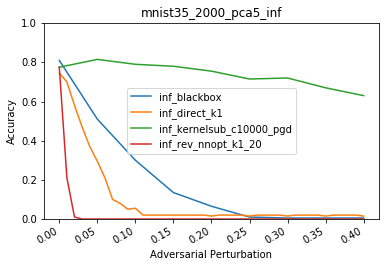

wine
('wine', 'knn1', 'inf', 'blackbox') 2
('wine', 'knn1', 'inf', 'direct_k1') 2
('wine', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('wine', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


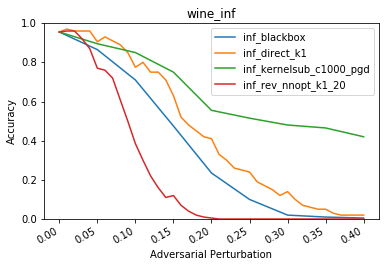

abalone
('abalone', 'knn1', 'inf', 'blackbox') 2
('abalone', 'knn1', 'inf', 'direct_k1') 2
('abalone', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('abalone', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


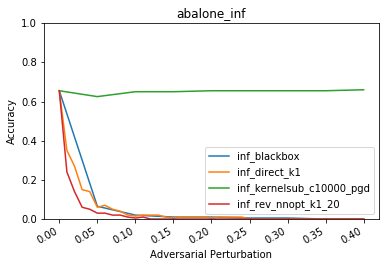

halfmoon_2000
('halfmoon_2000', 'knn1', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn1', 'inf', 'direct_k1') 2
('halfmoon_2000', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('halfmoon_2000', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


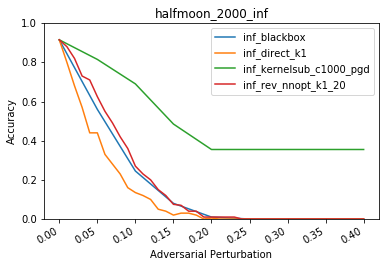

iris
('iris', 'knn1', 'inf', 'blackbox') 2
('iris', 'knn1', 'inf', 'direct_k1') 2
('iris', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('iris', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


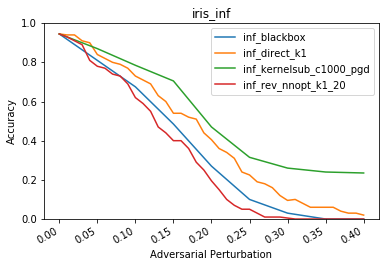

digits_pca5
('digits_pca5', 'knn1', 'inf', 'blackbox') 2
('digits_pca5', 'knn1', 'inf', 'direct_k1') 2
('digits_pca5', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('digits_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


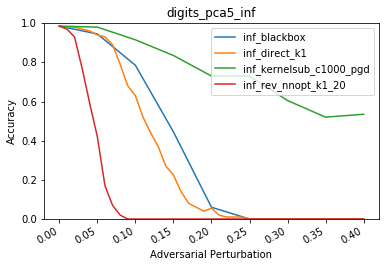

In [2]:
from params import nn_k1
exp_name = "adversarial_1nn"
_, grid_param, _ = nn_k1()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

44
{'mnist35_2000_pca5', 'wine', 'abalone', 'halfmoon_2000', 'iris', 'digits_pca5'}
mnist35_2000_pca5
('mnist35_2000_pca5', 'knn3', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn3', 'inf', 'direct_k3') 2
('mnist35_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


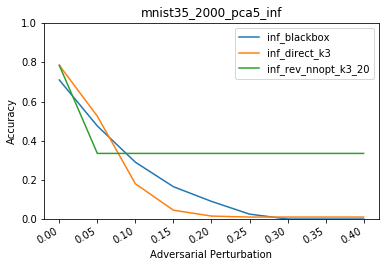

wine
('wine', 'knn3', 'inf', 'blackbox') 2
('wine', 'knn3', 'inf', 'direct_k3') 2
('wine', 'knn3', 'inf', 'rev_nnopt_k1_50') 2
('wine', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


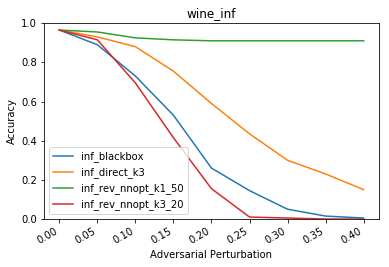

abalone
('abalone', 'knn3', 'inf', 'blackbox') 2
('abalone', 'knn3', 'inf', 'direct_k3') 2
('abalone', 'knn3', 'inf', 'rev_nnopt_k1_50') 2
('abalone', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


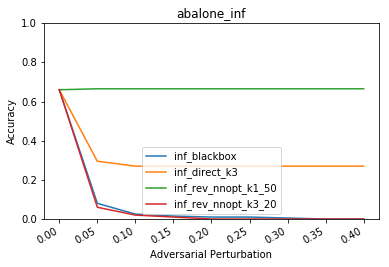

halfmoon_2000
('halfmoon_2000', 'knn3', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn3', 'inf', 'direct_k3') 2
('halfmoon_2000', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


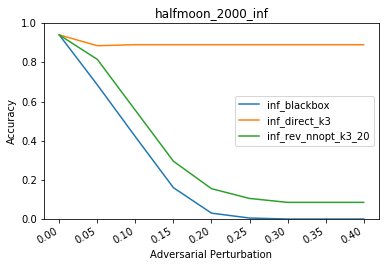

iris
('iris', 'knn3', 'inf', 'blackbox') 2
('iris', 'knn3', 'inf', 'direct_k3') 2
('iris', 'knn3', 'inf', 'rev_nnopt_k1_50') 2
('iris', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


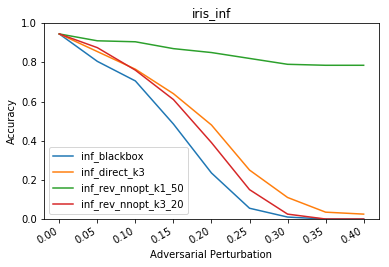

digits_pca5
('digits_pca5', 'knn3', 'inf', 'blackbox') 2
('digits_pca5', 'knn3', 'inf', 'direct_k3') 2
('digits_pca5', 'knn3', 'inf', 'rev_nnopt_k1_50') 2
('digits_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2


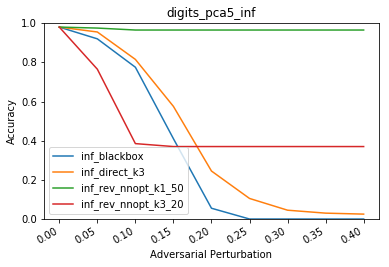

In [3]:
from params import nn_k3
exp_name = "3nn"
_, grid_param, _ = nn_k3()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

16
{'halfmoon_2000', 'mnist35_2000_pca5', 'abalone'}
halfmoon_2000
('halfmoon_2000', 'robust1nn', 'inf', 'blackbox') 2
('halfmoon_2000', 'robust1nn', 'inf', 'direct_k1') 2
('halfmoon_2000', 'robust1nn', 'inf', 'kernelsub_c10_pgd') 2
('halfmoon_2000', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


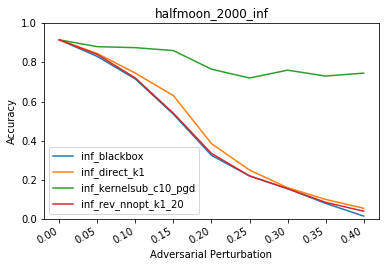

mnist35_2000_pca5
('mnist35_2000_pca5', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 2
('mnist35_2000_pca5', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


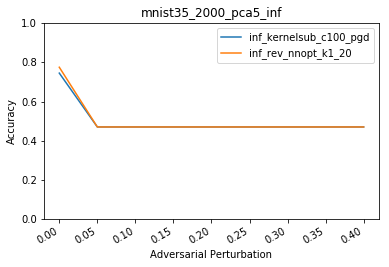

abalone
('abalone', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 2
('abalone', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


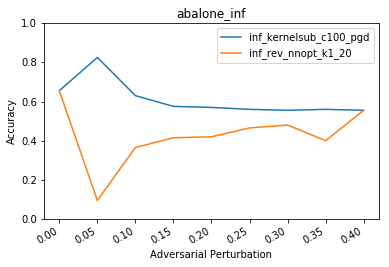

In [4]:
from params import robust_nn_k1
exp_name = "robust_1nn"
_, grid_param, _ = robust_nn_k1()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()